In [1]:
import matplotlib.pyplot as plt
import numpy as np

from scipy import fft, stats, interpolate
import seaborn as sns

import pandas as pd

nb_of_bar = 200

## Create Basic Signals

### Top Hat

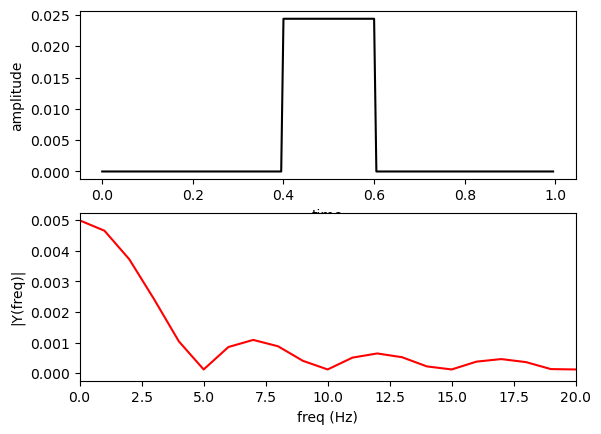

In [2]:
def get_tophat(t1, t2, Fs = 1000, start_time = 0.0, end_time = 1.0):
    Ts = 1.0/Fs                      # sampling interval
    x = np.arange(0,Fs,1)
    t = np.arange(0,1,Ts)            # time vector
    
    x1 = x[t == t1]
    x2 = x[t == t2]
        
    nZeros = x1
    nPulse = x2 - x1 + 1

    y = np.zeros(nZeros)
    y = np.append(y, np.ones(nPulse))
    y = np.append(y, np.zeros(Fs-nPulse - nZeros))
    
    y = y[(t >= start_time) & (t <= end_time)]
    t = t[(t >= start_time) & (t <= end_time)]
    
    y = y/sum(y)
    
    return t, y

mean = 0.5
Fs = nb_of_bar
width_tophat = 1/10

t_tophat, y_tophat = get_tophat(mean - width_tophat, mean + width_tophat, Fs)

plt.subplot(2,1,1)
plt.plot(t_tophat,y_tophat,'k-')
plt.xlabel('time')
plt.ylabel('amplitude')

plt.subplot(2,1,2)
n = len(y_tophat)                       # length of the signal
k = np.arange(n)
T = n/Fs
frq = k/T # two sides frequency range
freq_tophat = frq[range(int(n/2))]           # one side frequency range

Y_tophat = np.fft.fft(y_tophat)/n              # fft computing and normalization
Y_tophat = Y_tophat[range(int(n/2))]
# Y_tophat = Y_tophat / Y_tophat[0]

plt.plot(freq_tophat, abs(Y_tophat), 'r-')
plt.xlabel('freq (Hz)')
plt.ylabel('|Y(freq)|')
plt.xlim([0, 20])
plt.show()

### Gaussian

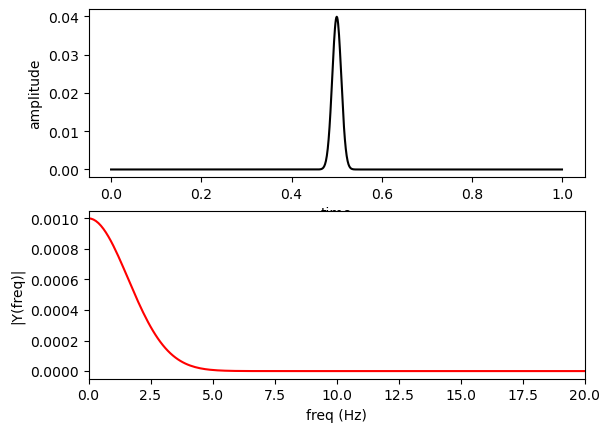

In [3]:
def get_gaussian(t_mean, std_dev, Fs = 1000, start_time = 0.0, end_time = 1.0):

    Ts = 1.0/Fs                      # sampling interval
    x = np.arange(0,Fs,1)
    t = np.arange(0,1,Ts)            # time vector

    mean = x[t == t_mean]
    std_dev *= Fs
    
    y = (np.e**-(((x-mean)**2)/(2*std_dev**2)))/(std_dev*np.sqrt(2*np.pi))
    
    y = y[(t >= start_time) & (t <= end_time)]
    t = t[(t >= start_time) & (t <= end_time)]
    
    y = y/sum(y)
    
    return t, y

Fs = 100
std_dev = 0.01
mean = 0.5

t, y = get_gaussian(mean, std_dev)


plt.subplot(2,1,1)
plt.plot(t,y,'k-')
plt.xlabel('time')
plt.ylabel('amplitude')
    
plt.subplot(2,1,2)
n = len(y)                       # length of the signal
k = np.arange(n)
T = n/Fs
frq = k/T # two sides frequency range
freq = frq[range(int(n/2))]           # one side frequency range

Y = np.fft.fft(y)/n              # fft computing and normalization
Y = Y[range(int(n/2))]
PSD = Y * np.conj(Y)

plt.plot(freq, abs(Y), 'r-')
plt.xlabel('freq (Hz)')
plt.ylabel('|Y(freq)|')
plt.xlim([0, 20])
plt.show()

### Sinusoidal

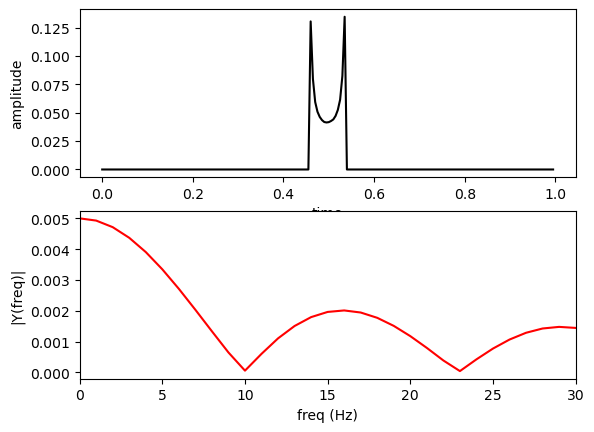

In [4]:
def get_sine(mean, width, Fs = 1000, start_time = 0.0, end_time = 1.0):

    # Parameters for the sine wave distribution
    amplitude = width/2  # Amplitude of the sine wave
    frequency = 5.0  # Frequency of the sine wave (cycles per unit)
    phase = 0.0      # Phase shift of the sine wave
    num_samples = 10000  # Number of data points to generate

    # Generate data points from the sine wave distribution
    x = np.linspace(0, 2 * np.pi, num_samples)  # Create an array of evenly spaced values from 0 to 2*pi
    sine_wave = amplitude * np.sin(2 * np.pi * frequency * x + phase)  # Compute the sine wave values

    start = -0.5
    end = 0.5

    bins = np.linspace(start, end, int(((end-start)*Fs+1)))
    weightsa = np.ones_like(sine_wave)/float(len(sine_wave))
    freq, edge = np.histogram(np.array(sine_wave), bins, weights = weightsa)

    t = np.array(edge[:-1]) + mean
    y = np.array(freq)
    
    y = y[(t >= start_time) & (t <= end_time)]
    t = t[(t >= start_time) & (t <= end_time)]
    
    y = y/sum(y)
    
    return t, y

null_freq = 10

Fs = nb_of_bar
mean = 0.5
width = 0.765 / null_freq

t, y = get_sine(mean, width, Fs)

plt.subplot(2,1,1)
plt.plot(t,y,'k-')
plt.xlabel('time')
plt.ylabel('amplitude')
    
plt.subplot(2,1,2)
n = len(y)                       # length of the signal
k = np.arange(n)
T = n/Fs
frq = k/T # two sides frequency range
freq = frq[range(int(n/2))]           # one side frequency range

Y = np.fft.fft(y)/n              # fft computing and normalization
Y = Y[range(int(n/2))]
PSD = Y * np.conj(Y)

plt.plot(freq, abs(Y), 'r-')
plt.xlabel('freq (Hz)')
plt.ylabel('|Y(freq)|')
plt.xlim([0, 30])

plt.show()

## Convoluted singals

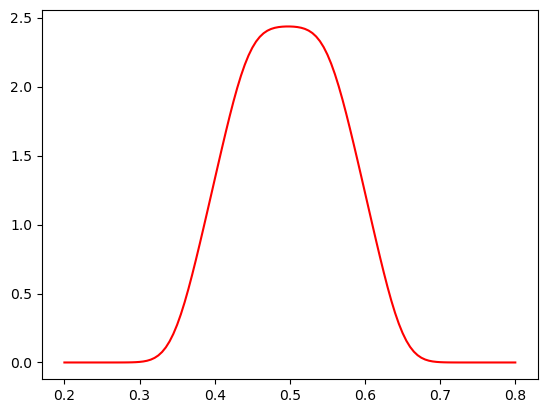

In [5]:
Fs = nb_of_bar
start_time = 0.2
end_time = 0.8

t, y_gaussian = get_gaussian(0.5, 0.024, Fs, start_time, end_time)

null_freq = 10

mean = 0.5
width_sine = 0.765 / null_freq
width_tophat = 0.2 ## from specs, 0.4 - 0.6s
width_dd = 0.5/null_freq

t, y_sine = get_sine(mean, width_sine, Fs, start_time, end_time)
t, y_hat = get_tophat(mean - width_tophat/2, mean + width_tophat/2, Fs, start_time, end_time)
# t, y_dd = get_double_dirac(mean - width_dd, mean + width_dd, Fs, start_time, end_time)

y_conv_ident = np.convolve(y_sine, y_gaussian, 'same')
y_conv_ident = np.convolve(y_conv_ident, y_hat, 'same')

plt.plot(t,y_conv_ident*100,'r-')

### Generate Random Variables

In [6]:
def get_function(mean, std_dev, null_freq, Fs = 1000, start_time = 0.0, end_time = 1.0):
    width_sine = 0.765 / null_freq
    width_tophat = 1 / null_freq
    width_dd = 0.5/null_freq

    t, y_sine = get_sine(mean, width_sine, Fs, start_time, end_time)
    t, y_hat = get_tophat(mean - width_tophat, mean + width_tophat, Fs, start_time, end_time)
    t, y_gaussian = get_gaussian(mean, std_dev, Fs, start_time, end_time)

    y_conv_ident = np.convolve(y_sine, y_gaussian, 'same')
    y_conv_ident = np.convolve(y_conv_ident, y_hat, 'same')
    
    return t, y_conv_ident

def sample(mean, std_dev, null_freq, Fs = 1000, start_time = 0.0, end_time = 1.0):
    x, y = get_function(mean, std_dev, null_freq, nb_samples, start_time, end_time)
        
    cdf_y = np.cumsum(y)            # cumulative distribution function, cdf
    cdf_y = cdf_y/cdf_y.max()       # takes care of normalizing cdf to 1.0
    inverse_cdf = interpolate.interp1d(cdf_y,x)    # this is a function
    return inverse_cdf

def get_samples(mean, std_dev, null_freq, N = 1000, start_time = 0.0, end_time = 1.0):
    # let's generate some samples according to the chosen pdf, f(x)
    uniform_samples = np.random.random(int(N))
    
    samples = sample(mean, std_dev, null_freq, nb_samples, start_time, end_time)(uniform_samples)
    
    return samples

Text(0, 0.5, 'Probability Density [%]')

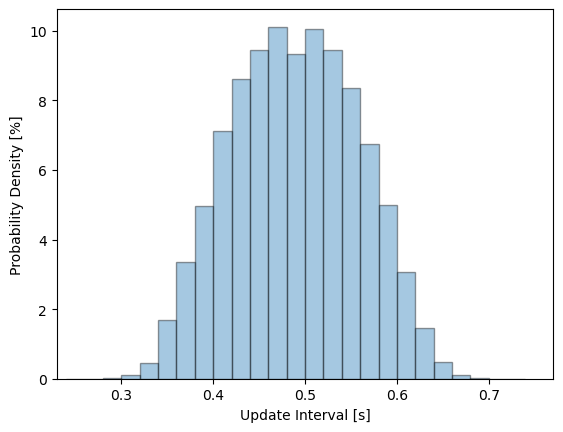

In [7]:
start = 0.25
end = 0.75
nb_of_bar = 50


## The estimations
nb_samples = 1000
mean = 0.5
null_freq = 10
start_time = 0.0
end_time = 1.0
std_dev = 0.024
    
samples_list = get_samples(mean, std_dev, null_freq, N = 10000, start_time = 0.25, end_time = 0.75)
bins = np.linspace(start, end, int(((end-start)*nb_of_bar+1)))
weightsa = np.ones_like(samples_list)/float(len(samples_list))
freq_sample, edge_sample = np.histogram(np.array(samples_list), bins, weights = weightsa)

## The plots
plt.bar(edge_sample[:-1], freq_sample*100, width = 1/nb_of_bar, edgecolor = 'k', alpha = 0.4)

plt.xlim([start-(1/nb_of_bar), end+(1/nb_of_bar)])
# plt.title('One Aircraft')
plt.xlabel('Update Interval [s]')
plt.ylabel('Probability Density [%]')

In [8]:
samples_list = get_samples(mean, std_dev, null_freq, N = 1, start_time = 0.25, end_time = 0.75)
print(samples_list)

[0.47977165]


## Create Transmission With Probability

In [9]:
def function_hist(a, ini, final, nb_of_bar):
    bins = np.linspace(ini, final, int((final-ini)*nb_of_bar+1))
    weightsa = np.ones_like(a)/float(len(a))
    freq, edge = np.histogram(np.array(a), bins, weights = weightsa)

    sum_list = []
    sum_var = 0
    
    for f in freq:
        sum_var += f
        sum_list.append(sum_var)
        
    return freq, edge, np.array(sum_list)

In [10]:
def get_sim_hist(broadcast_interval, std_dev, update_probability, nb_of_bar = 50, null_freq = 10):   
    
    mean = 0.5
    
    nb_aircraft = 100
    lastupdate = np.zeros(nb_aircraft) + get_samples(mean, std_dev, null_freq, N = nb_aircraft, start_time = 0.0, end_time = 1.0)

    simt = 0
    total_simtime = 1000

    # initialize time elapsed log
    time_elapsed_total = []

    # initialize counter
    counts_sent = {}

    # get the update probability from the CDF
    update_prob = np.zeros(nb_aircraft) + update_probability

    while simt <= total_simtime:
        simt += broadcast_interval

        # time elapsed is the difference between the current time and the lastupdate
        time_elapsed = simt - (lastupdate + get_samples(mean, std_dev, null_freq, N = nb_aircraft, start_time = 0.0, end_time = 1.0))

        # select the updated index based on a randomized value and the update probability
        cond = np.random.random(size = nb_aircraft) < update_prob
        up = np.where(cond)

        # count the value of each sent data
        for value in time_elapsed[up]:
            if value in counts_sent:
                counts_sent[value] += 1
            else:
                counts_sent[value] = 1

        # update the lastupdate of each sent data and log the time elapsed for sent data
        lastupdate[up] = simt
        time_elapsed_total.extend(time_elapsed[up])

    time_elapsed_total = np.array(time_elapsed_total)
    time_elapsed_total = time_elapsed_total[time_elapsed_total > 0.2]
    
    freq, edge, sum_ = function_hist(time_elapsed_total, 0.0, 4, nb_of_bar)
    
    return time_elapsed_total, freq, edge, sum_

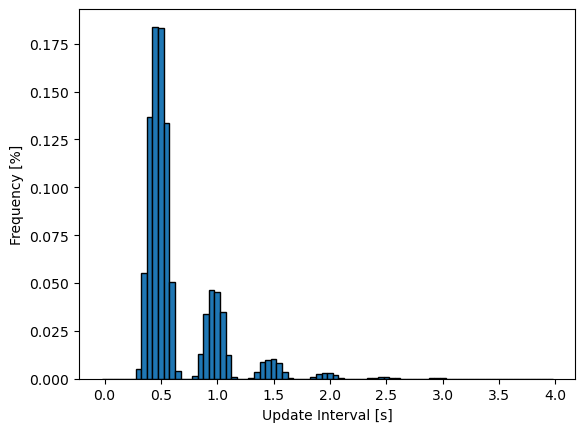

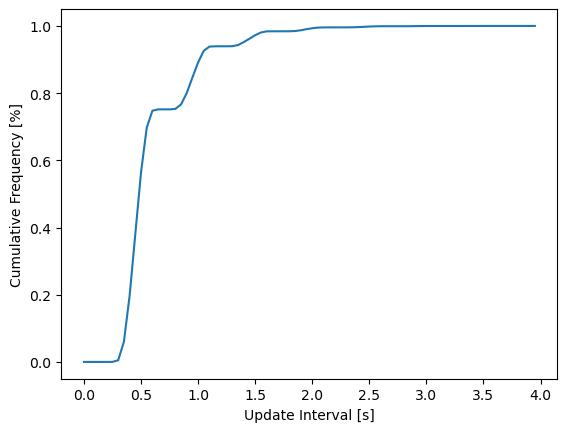

In [11]:
broadcast_interval = 0.5
std_dev = 0.024
update_probability = 0.75

nb_of_bar = 20
sample_sim, freq_sim, edge_sim, cum_sim = get_sim_hist(broadcast_interval, std_dev, update_probability, nb_of_bar)

plt.bar(edge_sim[:-1], freq_sim, width = 1/nb_of_bar, edgecolor = 'k')
plt.xlabel('Update Interval [s]')
plt.ylabel('Frequency [%]')
plt.show()

plt.plot(edge_sim[:-1], cum_sim)
plt.xlabel('Update Interval [s]')
plt.ylabel('Cumulative Frequency [%]')
plt.show()


## Load saved data from OpenSky

In [14]:
df = pd.read_csv('pos_tables/pos_table_1433801924.csv')
df = df.drop(df.columns[0], axis=1)
df.drop_duplicates(subset=['rawmsg'], inplace = True)
df.dropna(subset=["lat"], inplace=True)
df.dropna(subset=["lon"], inplace=True)
df.dropna(subset=["lat"], inplace=True)

df_grouped = df.groupby('icao24', group_keys=True).apply(lambda x: x)
df_grouped['updateinterval'] = df_grouped['mintime'].diff()

In [15]:
df_grouped = df_grouped[(df_grouped['updateinterval'] > 0.0) & (df_grouped['updateinterval'] < 5)]
df = df_grouped.reset_index(drop=True)

In [16]:
df['mintime'][5] - df['mintime'][0]

5.980000019073486

In [17]:
from math import radians, sin, cos, sqrt, atan2

def haversine(lat1, lon1, lat_receiver, lon_receiver):
    R = 6371.0  # radius of the Earth in km

    lat1_rad = radians(lat1)
    lon1_rad = radians(lon1)
    lat_receiver_rad = radians(lat_receiver)
    lon_receiver_rad = radians(lon_receiver)

    dlon = lon_receiver_rad - lon1_rad
    dlat = lat_receiver_rad - lat1_rad

    a = sin(dlat / 2)**2 + cos(lat1_rad) * cos(lat_receiver_rad) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance  # in km

lat_receiver = 43.57124934563629
lon_receiver = 1.4722830959048443

df['range_km'] = df.apply(lambda row: haversine(row['lat'], row['lon'], lat_receiver, lon_receiver), axis=1)

In [18]:
df_range_all = []

bin_width = 50
max_range = max(df['range_km'])
nb_of_cat = int(np.floor(max_range/bin_width))

for i in range(nb_of_cat):
    df_here = df[(df['range_km'] > i*bin_width) & (df['range_km'] <= (i+1)*bin_width)]
    df_range_all.append(df_here)

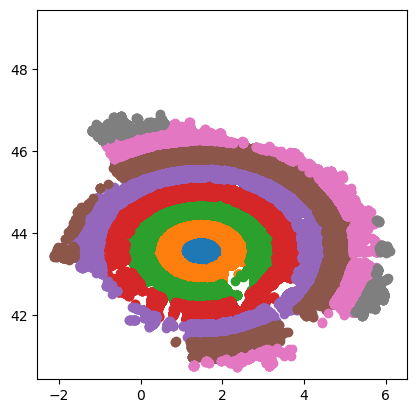

In [19]:
for df_range in df_range_all:
    plt.scatter(df_range['lon'], df_range['lat'])
    
plt.axis('square');

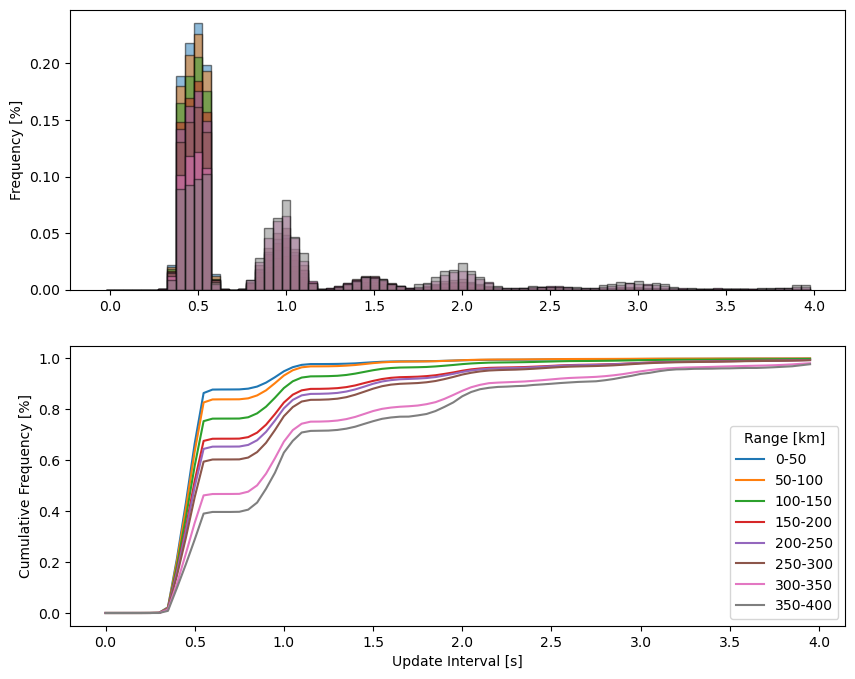

In [20]:
legend = []
i = 0

fig, axs = plt.subplots(nrows=2, figsize=(10, 8))

for df_range in df_range_all:
    legend.append('{}-{}'.format(i*bin_width, (i+1)*bin_width))
    i+=1
    start_time = 0.0
    end_time = max(edge_sim)

    freq_opensky, edge_opensky, cum_opensky = function_hist(df_range['updateinterval'].to_list(), start_time, end_time, nb_of_bar)

    axs[0].bar(edge_opensky[:-1], freq_opensky, width = 1/nb_of_bar, edgecolor = 'k', alpha = 0.5)
    # plt.bar(edge_sim[:-1], freq_sim, width = 1/nb_of_bar, edgecolor = 'k')
#     plt.xlabel('Update Interval [s]')
    axs[0].set_ylabel('Frequency [%]')
#     # plt.xlim([-0.1, 2.1])
#     plt.title('One Receiver')

    axs[1].plot(edge_opensky[:-1], cum_opensky, label = 'OpenSky')
    # plt.plot(edge_sim[:-1], cum_sim)
    # plt.plot(edge[:-1], cum, label = 'Simulation')
    axs[1].set_xlabel('Update Interval [s]')
    axs[1].set_ylabel('Cumulative Frequency [%]')

axs[1].legend(legend, title = 'Range [km]', loc = 'lower right')
    


## Gradient Descent

In [21]:
def loss_function(update_probability):
    
#     if(update_probability > 1.0):
#         update_probability = 1.0
        
    sample_sim, freq_sim, edge_sim, cum_sim = get_sim_hist(broadcast_interval, std_dev, update_probability, nb_of_bar)
    
    freq_opensky, edge_opensky, cum_opensky = function_hist(input_data, start_time, end_time, nb_of_bar)
    
    statistic, p_value = stats.ks_2samp(sample_sim, input_data)

    return statistic

def numerical_gradient(f, x, epsilon=1e-2):
    
    if ((x + epsilon) > 1):
        epsilon = 1 - x
        
    gradient = (f(x + epsilon) - f(x - epsilon)) / (2 * epsilon)
    return gradient

def gradient_descent(input_data, initial_x = 0.85, learning_rate = 0.005, stop_delta = 1e-4, max_iter = 50):
    # Gradient Descent parameters
    num_iterations = 0

    # Perform gradient descent
    x = initial_x
    prev_x = 0.0

    while((abs(x - prev_x) > stop_delta) and (num_iterations < max_iter)):
        num_iterations += 1
        gradient = numerical_gradient(loss_function, x)
        prev_x = x
        x -= learning_rate * gradient

        print(round(x, 4), round(abs(x - prev_x), 4), num_iterations)
        
    return x

In [22]:
input_data = df_range_all[0]['updateinterval'].to_list()

update_prob = gradient_descent(input_data, initial_x = 0.95, learning_rate = 0.002)

0.9477 0.0023 1
0.9453 0.0024 2


KeyboardInterrupt: 

In [23]:
def get_comparison(update_probability, input_update_interval):
    nb_of_bar = 50
    sample_sim, freq_sim, edge_sim, cum_sim = get_sim_hist(broadcast_interval, std_dev, update_probability, nb_of_bar)

    start_time = 0.0
    end_time = max(edge_sim)
    sample_size = 1000

    freq_opensky, edge_opensky, cum_opensky = function_hist(input_update_interval, start_time, end_time, nb_of_bar)

    fig, axs = plt.subplots(nrows=3, figsize=(10, 9))
    plt.subplots_adjust(hspace=0.5)

    axs[0].bar(edge_opensky[:-1], freq_opensky*100, width = 1/nb_of_bar, edgecolor = 'k', alpha = 0.5)
    axs[0].bar(edge_sim[:-1], freq_sim*100, width = 1/nb_of_bar, edgecolor = 'k', alpha = 0.5)
    axs[0].set_ylabel('Frequency [%]')

    axs[1].plot(edge_opensky[:-1], cum_opensky*100, label = 'OpenSky')
    axs[1].plot(edge_sim[:-1], cum_sim*100)
    axs[1].set_ylabel('Cumulative Frequency [%]')

    diff = (cum_opensky - cum_sim)*100

    axs[2].plot(edge_opensky[:-1], diff, label = 'OpenSky')
    axs[2].set_xlabel('Update Interval [s]')
    axs[2].set_ylabel('Cumulative Diff [%]')
    
    plt.show()

    max_diff_graph = max(abs(diff))
    
    print("Size: {}, {}".format(len(sample_sim), len(input_update_interval)))
    max_diff, p_value = stats.ks_2samp(sample_sim[:sample_size], input_update_interval[:sample_size])
    
    return max_diff_graph, max_diff, p_value

## Identify Update Probability

In [24]:
df1 = pd.read_csv('pos_tables/pos_table_1433801924_4320_2023-06-15.csv')
df2 = pd.read_csv('pos_tables/pos_table_1433801924_4320_2023-01-01.csv')
df3 = pd.read_csv('pos_tables/pos_table_1433801924_1440_2022-07-01.csv')
df4 = pd.read_csv('pos_tables/pos_table_1433801924_1440_2022-07-02.csv')
df5 = pd.read_csv('pos_tables/pos_table_1433801924_1440_2022-07-03.csv')
df6 = pd.read_csv('pos_tables/pos_table_1433801924_1440_2022-07-04.csv')
df7 = pd.read_csv('pos_tables/pos_table_1433801924_1440_2022-07-05.csv')


In [25]:
df_list = [df1, df2, df3, df4, df5, df6, df7]

df_filtered = []

for df_ in df_list:
    df_filtered_ = df_[['mintime', 'maxtime', 'rawmsg', 'icao24', 'lat', 'lon', 'alt', 'serial', 'nb_of_traffic']]
    df_filtered.append(df_filtered_)
    
    # df = pd.concat([df1, df2, df3, df4, df5, df6, df7])
df = pd.concat(df_filtered)

df.drop_duplicates(subset=['rawmsg'], inplace = True)
df.dropna(subset=["lat"], inplace=True)
df.dropna(subset=["lon"], inplace=True)
df.dropna(subset=["lat"], inplace=True)

df_grouped = df.groupby('icao24', group_keys=True).apply(lambda x: x)
df_grouped['updateinterval'] = df_grouped['mintime'].diff()

df_grouped = df_grouped[(df_grouped['updateinterval'] > 0.0) & (df_grouped['updateinterval'] < 10)]
df = df_grouped.reset_index(drop=True)

df

,mintime,maxtime,rawmsg,icao24,lat,lon,alt,serial,nb_of_traffic,updateinterval
0,1.686917e+09,1.686917e+09,8d00000158bf0264245b1226afe3,000001,45.586761,1.561800,11277.6,1433801924,136,0.978
1,1.686917e+09,1.686917e+09,8d00000158bf0263f65b78516390,000001,45.585709,1.568633,11277.6,1433801924,136,2.111
2,1.686917e+09,1.686917e+09,8d00000158bf05e24c593d954d8f,000001,45.585720,1.568642,11277.6,1433801924,136,0.508
3,1.686917e+09,1.686917e+09,8d00000158bf0263d05bdc3e1979,000001,45.584839,1.575332,11277.6,1433801924,136,1.417
4,1.686917e+09,1.686917e+09,8d00000158bf05e21059d19e0e8b,000001,45.584324,1.578804,11277.6,1433801924,136,1.429
...,...,...,...,...,...,...,...,...,...,...
3683105,1.686846e+09,1.686846e+09,8de8042258ab05f19212fa42ab0c,e80422,45.676730,0.333572,10058.4,1433801924,119,0.438
3683106,1.686846e+09,1.686846e+09,8de8042258ab05f17212f2675bb6,e80422,45.675985,0.333023,10058.4,1433801924,119,0.520
3683107,1.686846e+09,1.686846e+09,8de8042258ab02730a13564c80b8,e80422,45.674057,0.331600,10058.4,1433801924,119,0.870
3683108,1.686846e+09,1.686846e+09,8de8042258ab0272ea134e426d89,e80422,45.673325,0.331064,10058.4,1433801924,119,0.420


In [68]:
def haversine(lat1, lon1, lat_receiver, lon_receiver):
    R = 6371.0  # radius of the Earth in km

    lat1_rad = radians(lat1)
    lon1_rad = radians(lon1)
    lat_receiver_rad = radians(lat_receiver)
    lon_receiver_rad = radians(lon_receiver)

    dlon = lon_receiver_rad - lon1_rad
    dlat = lat_receiver_rad - lat1_rad

    a = sin(dlat / 2)**2 + cos(lat1_rad) * cos(lat_receiver_rad) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance  # in km

lat_receiver = 43.57124934563629
lon_receiver = 1.4722830959048443

df['range_km'] = df.apply(lambda row: haversine(row['lat'], row['lon'], lat_receiver, lon_receiver), axis=1)
df['range_lat_km'] = df.apply(lambda row: haversine(row['lat'], lon_receiver, lat_receiver, lon_receiver), axis=1)
df['range_lon_km'] = df.apply(lambda row: haversine(lat_receiver, row['lon'], lat_receiver, lon_receiver), axis=1)

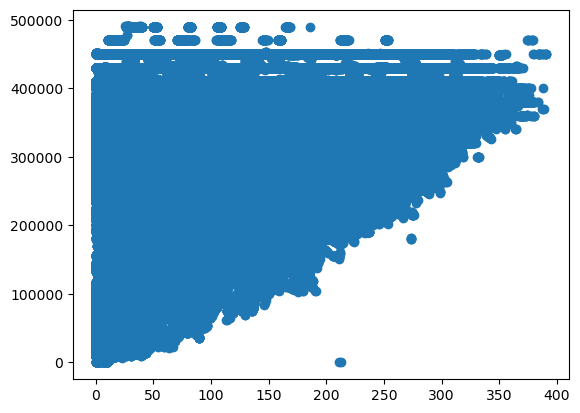

In [74]:
plt.scatter(df['range_lon_km'], df['alt']*3280.84/100)

Text(0, 0.5, 'Altitude [FL]')

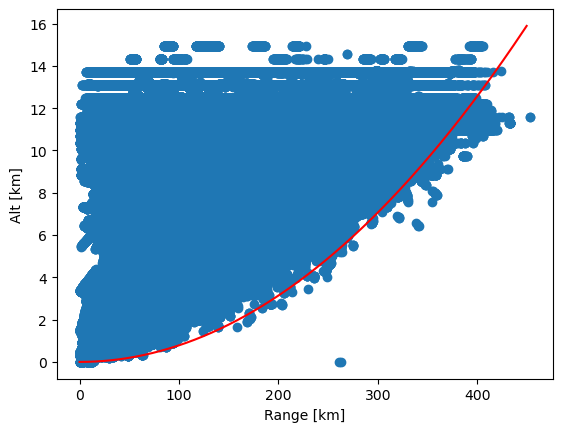

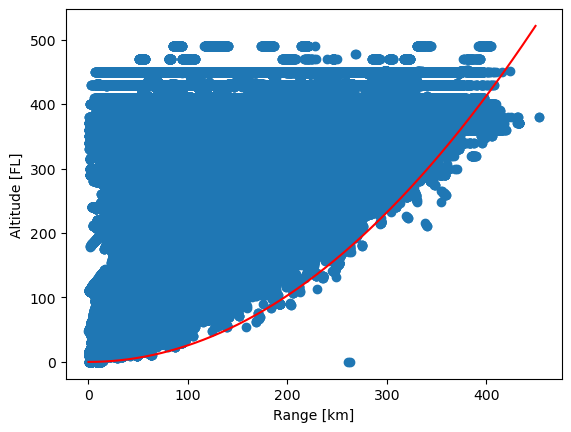

In [102]:
R = 6371.0
X = np.arange(0, 450, 0.5)
h = []

for x in X:
    cos_teta = np.cos(x/R)
    h.append(R/cos_teta - R)
    
h = np.array(h)

plt.figure()
plt.scatter(df['range_km'], df['alt']/1000)
plt.plot(X, h, color = 'r')
plt.xlabel('Range [km]')
plt.ylabel('Alt [km]')

plt.figure()
plt.scatter(df['range_km'], df['alt']*3.28084/100)
plt.plot(X, h*3280.84/100, color = 'r')
plt.xlabel('Range [km]')
plt.ylabel('Altitude [FL]')

(0.0, 16.0)

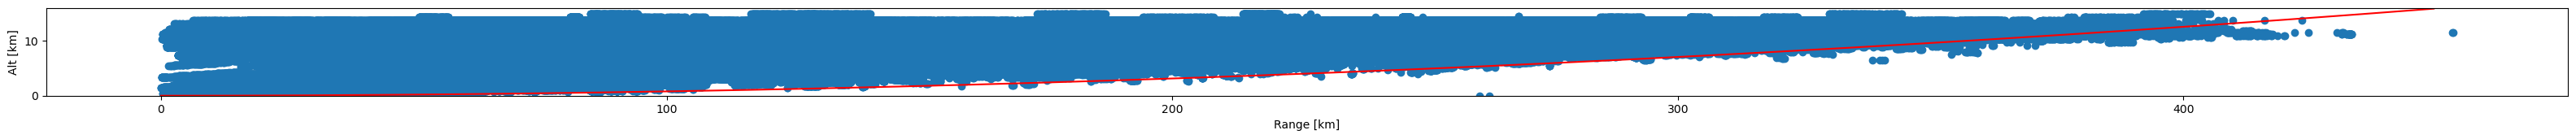

In [101]:
plt.figure(figsize=(40, 1.4))
plt.scatter(df['range_km'], df['alt']/1000)
plt.plot(X, h, color = 'r')
plt.xlabel('Range [km]')
plt.ylabel('Alt [km]')
# plt.axis('equal')
plt.ylim([0, 16])

In [93]:
h[100]*3280.84/100

6.437223747260604

In [27]:
df_all_bin = []
df_all_bin_size = []

traf_bin_width = 30
range_bin_width = 50

max_traf = max(df['nb_of_traffic'])
max_range = 400

nb_of_cat_range = int(np.floor(max_range/range_bin_width))
nb_of_cat_traf = int(np.floor(max_traf/traf_bin_width))

for i in range(nb_of_cat_range):
    df_range_all = []
    df_range_all_size = []
    
    for j in range(nb_of_cat_traf):
#         print('Range:{}-{}, Traf:{}-{}'.format(i*range_bin_width, (i+1)*range_bin_width, j*traf_bin_width, (j+1)*traf_bin_width))
        traf_crit = ((df['nb_of_traffic'] > j*traf_bin_width) & (df['nb_of_traffic'] <= (j+1)*traf_bin_width))
        range_crit = ((df['range_km'] > i*range_bin_width) & (df['range_km'] <= (i+1)*range_bin_width))
        
        all_crit = traf_crit & range_crit
        
        df_range_all.append(df[all_crit])
        df_range_all_size.append(len(df[all_crit]))
        
    df_all_bin.append(df_range_all)
    df_all_bin_size.append(df_range_all_size)
        
#     df_here = df[(df['range_km'] > i*bin_width) & (df['range_km'] <= (i+1)*bin_width)]
#     df_range_all.append(df_here)

[ 50 100 150 200 250 300 350]


(0.0, 8.0, 5.0, 0.0)

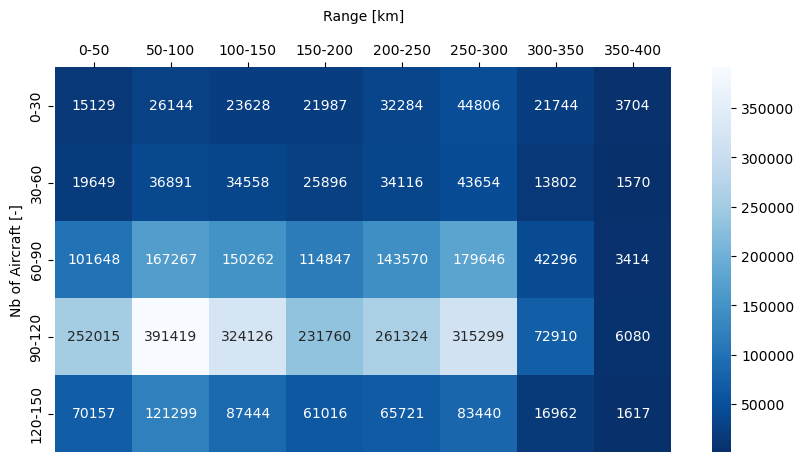

In [28]:
# Create a grid of x and y values
range_arr = np.arange(range_bin_width, max_range, range_bin_width)
traf_arr = np.arange(traf_bin_width, max_traf, traf_bin_width)
X, Y = np.meshgrid(range_arr, traf_arr)

print(range_arr)

# R_np = np.array(R_list)
data_size = np.array(df_all_bin_size).T
# data_flipped = data_size[::-1]

range_labels = ['{}-{}'.format(i*range_bin_width, (i+1)*range_bin_width) for i in range(nb_of_cat_range)]
traf_labels = ['{}-{}'.format(i*traf_bin_width, (i+1)*traf_bin_width) for i in range(nb_of_cat_traf)]
# traf_labels = traf_labels[::-1]

# Create a filled contour plot
plt.figure(figsize=(10, 5))
cmap_reversed = plt.get_cmap('coolwarm_r')  # Get the reversed colormap
sns.heatmap(data_size, annot=True, cmap='Blues_r', fmt='.0f', cbar=True, xticklabels=range_labels, yticklabels=traf_labels)
# Set axis labels and plot title
plt.xlabel('Range [km]')

ax = plt.gca()
ax.xaxis.set_label_coords(0.5, 1.15)  # Adjust the label position to be at the top
ax.xaxis.set_ticks_position('top')

plt.ylabel('Nb of Aircraft [-]')
plt.axis('equal')
# plt.title('Annotated Heatmap Example')

0.46691783990992847
0.44674029212697697
0.42936407996172
0.40273793226573207
0.39460068132841397
0.46748776009802717
0.4363665934781571
0.41120484016588127
0.37127988166197
0.34962365724306965
0.4477738276617867
0.40873314427945934
0.3709986556816991
0.3255215564313227
0.29409679337631484
0.4283440214673459
0.3756950880446327
0.3243880989488249
0.28260269244015124
0.24716467811710902
0.42088960475766335
0.362762340251133
0.3118687748138977
0.25895057476579386
0.2294396007362981
0.40193277686051243
0.3399917533330954
0.28307337764270124
0.22654052185375836
0.20200143815909383
0.36400846210467347
0.25474568903061007
0.19791469642517825
0.16099300507479633
0.14084424006605356
0.29157667386608876
0.20636942675159234
0.15817223198593913
0.12006578947367953
0.1323438466295632


Text(0.08, 0.5, 'Nb of Aircraft [-]')

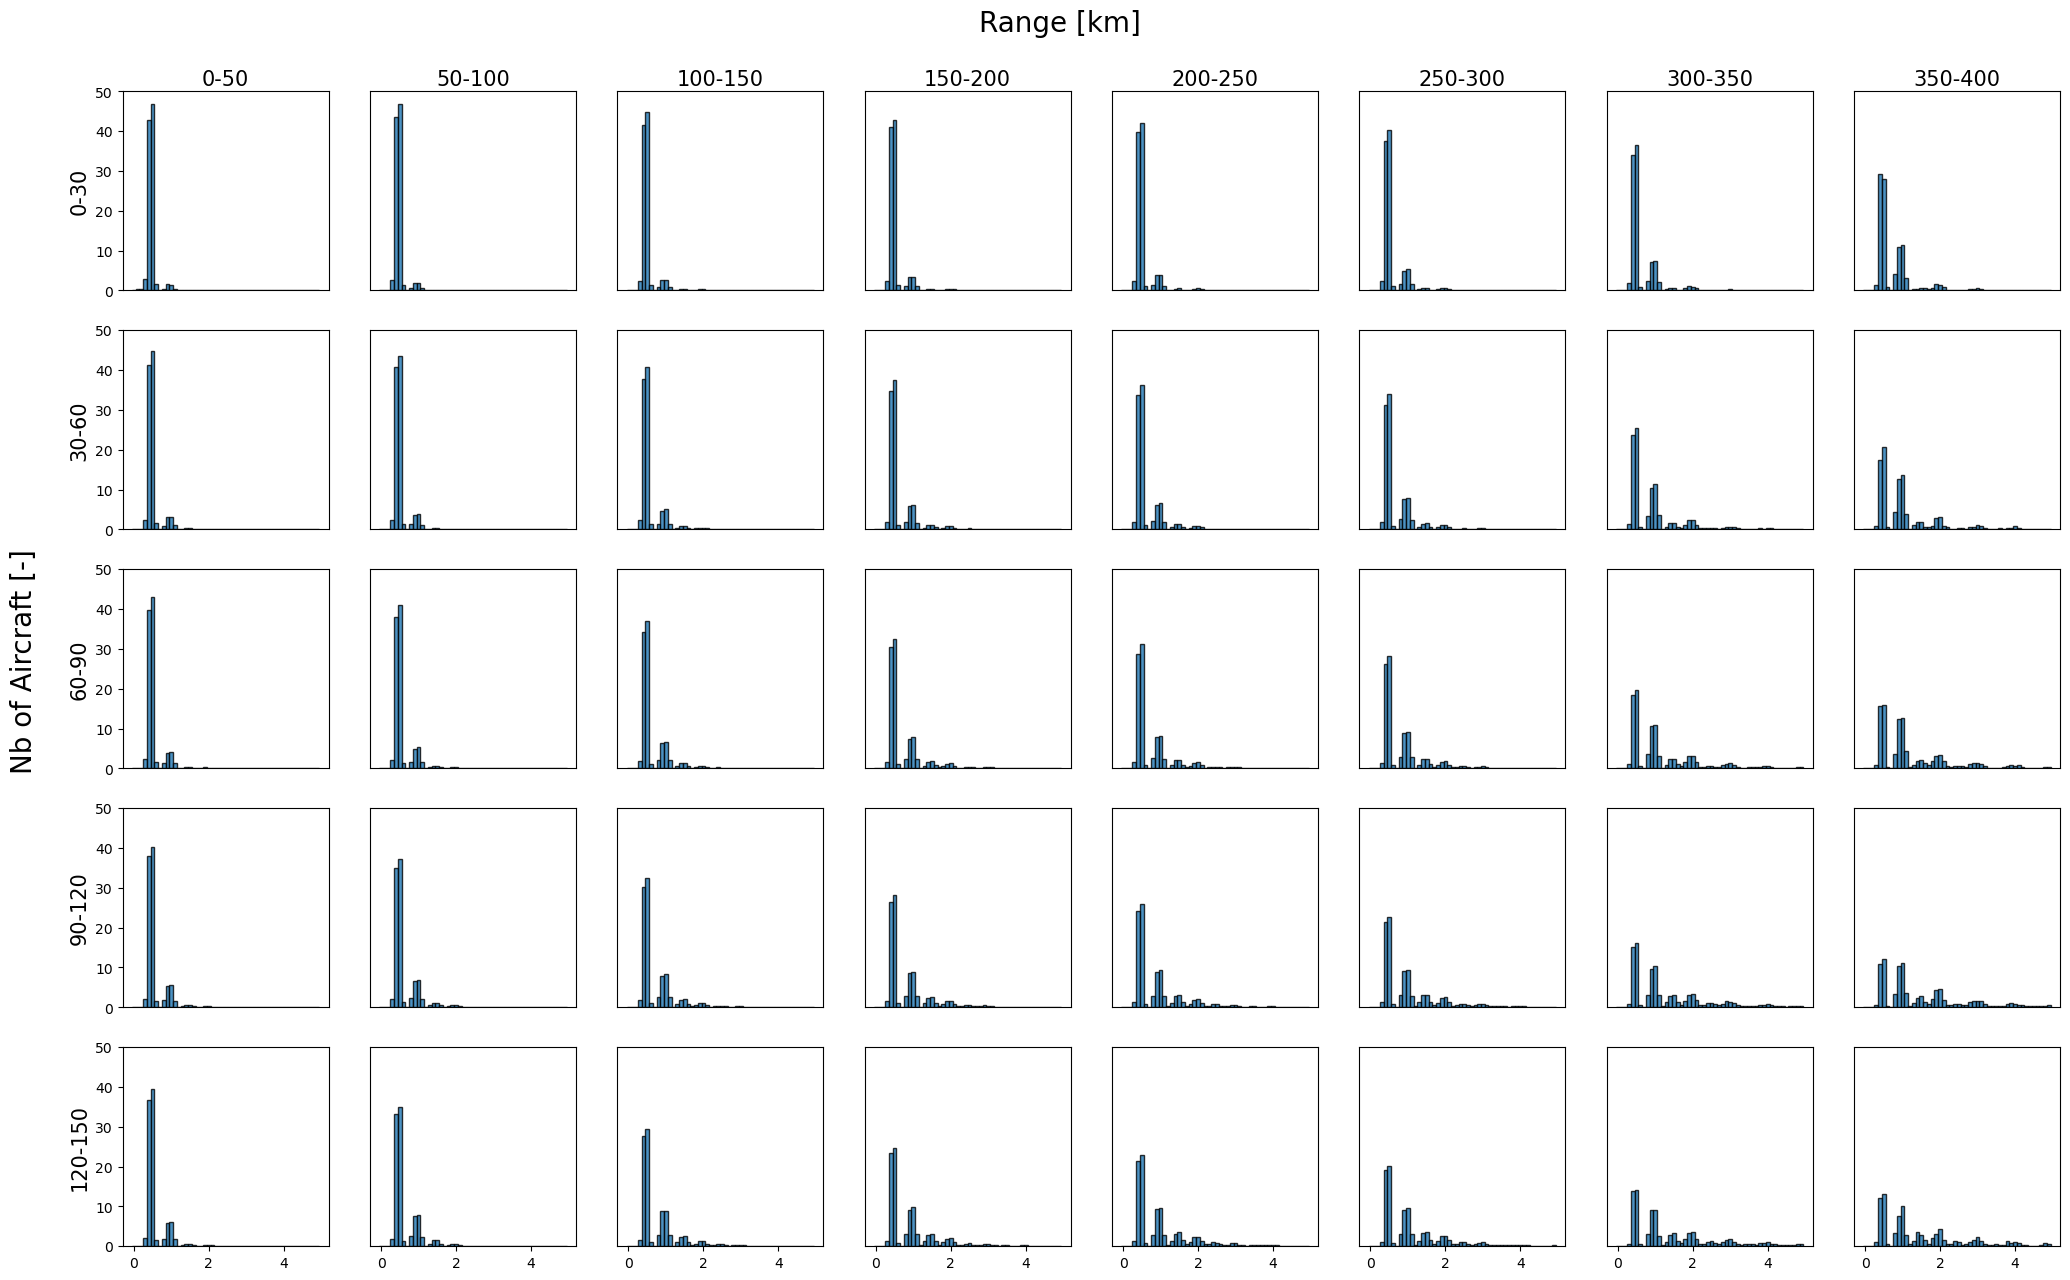

In [35]:
start = 0.0
end = 5.0
nb_of_bar = 10

range_idx = 0

fig, axs = plt.subplots(5, 8, figsize = (25,15))

for df_traf in df_all_bin:
    traf_idx = 0
    
    for df_loc in df_traf:
        input_list = np.array(df_loc['updateinterval'].to_list())
        
        bins = np.linspace(start, end, int(((end-start)*nb_of_bar+1)))
        weightsa = np.ones_like(input_list)/float(len(input_list))
        freq_, edge_ = np.histogram(input_list, bins, weights = weightsa)
        
        axs[traf_idx, range_idx].bar(edge_[:-1], freq_*100, width = 1/nb_of_bar, edgecolor = 'k', alpha = 0.8)
#         plt.title('Range: {}-{}\nTraf: {}-{}\nDataSize: {}'.format(range_idx*50, (range_idx+1)*50, traf_idx*30, (traf_idx+1)*30, len(input_list)))
        
#         plt.show()

        if(traf_idx != 4):
            axs[traf_idx, range_idx].set_xticks([])  # Remove x-axis labels
    
        if(range_idx != 0):
            axs[traf_idx, range_idx].set_yticks([])  # Remove y-axis labels
            
        axs[traf_idx, range_idx].set_ylim([0, 50])
        
        print(max(freq_))
        
        if(traf_idx == 0):
            axs[traf_idx, range_idx].xaxis.set_label_position('top')
            axs[traf_idx, range_idx].set_xlabel("{}-{}".format((range_idx*50), (range_idx+1)*50), fontsize = 15)
#             axs[traf_idx, range_idx].set_xlabel('a')
        
        if(range_idx == 0):
            axs[traf_idx, range_idx].set_ylabel("{}-{}".format((traf_idx*30), (traf_idx+1)*30), fontsize = 15)
# #             axs[traf_idx, range_idx].set_xlabel('a')

        traf_idx +=1
        
    range_idx +=1
    
fig.text(0.5, 0.92, 'Range [km]', ha='center', fontsize=20)
fig.text(0.08, 0.5, 'Nb of Aircraft [-]', va='center', rotation='vertical', fontsize=20)

In [38]:
def get_cum(freq):
    cum_list = []
    cum = 0
    
    for f in freq:
        cum += f
        cum_list.append(cum)
        
    return np.array(cum_list)

In [39]:
start = 0.0
end = 5.0
nb_of_bar = 10

range_idx = 0

# fig, axs = plt.subplots(5, 8, figsize = (25,15))

within_p5s = []
within_1s = []

for df_traf in df_all_bin:
    traf_idx = 0
    
    within_p5s_ = []
    within_1s_ = []
    
    for df_loc in df_traf:
        input_list = np.array(df_loc['updateinterval'].to_list())
        
        bins = np.linspace(start, end, int(((end-start)*nb_of_bar+1)))
        weightsa = np.ones_like(input_list)/float(len(input_list))
        freq_, edge_ = np.histogram(input_list, bins, weights = weightsa)
        
        freq_ = np.array(freq_)
        edge_ = np.array(edge_)
        cum_ = get_cum(freq_)
        
        within_p5s_.append(cum_[edge_[:-1] == 0.8][0]*100)
        within_1s_.append(cum_[edge_[:-1] == 1.3][0]*100)
        
        traf_idx +=1
        
    within_p5s.append(within_p5s_)
    within_1s.append(within_1s_)
        
    range_idx +=1
    
# fig.text(0.5, 0.92, 'Range [km]', ha='center', fontsize=20)
# fig.text(0.08, 0.5, 'Nb of Aircraft [-]', va='center', rotation='vertical', fontsize=20)

[ 50 100 150 200 250 300 350]


(0.0, 8.0, 5.0, 0.0)

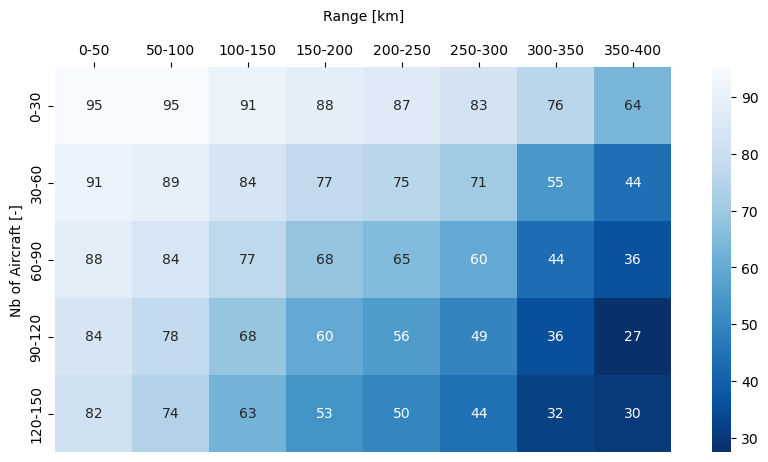

In [40]:
# Create a grid of x and y values
range_arr = np.arange(range_bin_width, max_range, range_bin_width)
traf_arr = np.arange(traf_bin_width, max_traf, traf_bin_width)
X, Y = np.meshgrid(range_arr, traf_arr)

print(range_arr)

# R_np = np.array(R_list)
within_1s_heatmap = np.array(within_1s).T
within_p5s_heatmap = np.array(within_p5s).T

# data_flipped = data_size[::-1]

range_labels = ['{}-{}'.format(i*range_bin_width, (i+1)*range_bin_width) for i in range(nb_of_cat_range)]
traf_labels = ['{}-{}'.format(i*traf_bin_width, (i+1)*traf_bin_width) for i in range(nb_of_cat_traf)]
# traf_labels = traf_labels[::-1]

# Create a filled contour plot
plt.figure(figsize=(10, 5))
cmap_reversed = plt.get_cmap('coolwarm_r')  # Get the reversed colormap
sns.heatmap(within_p5s_heatmap, annot=True, cmap='Blues_r', fmt='.0f', cbar=True, xticklabels=range_labels, yticklabels=traf_labels)
# Set axis labels and plot title
plt.xlabel('Range [km]')

ax = plt.gca()
ax.xaxis.set_label_coords(0.5, 1.15)  # Adjust the label position to be at the top
ax.xaxis.set_ticks_position('top')

plt.ylabel('Nb of Aircraft [-]')
plt.axis('equal')
# plt.title('Annotated Heatmap Example')

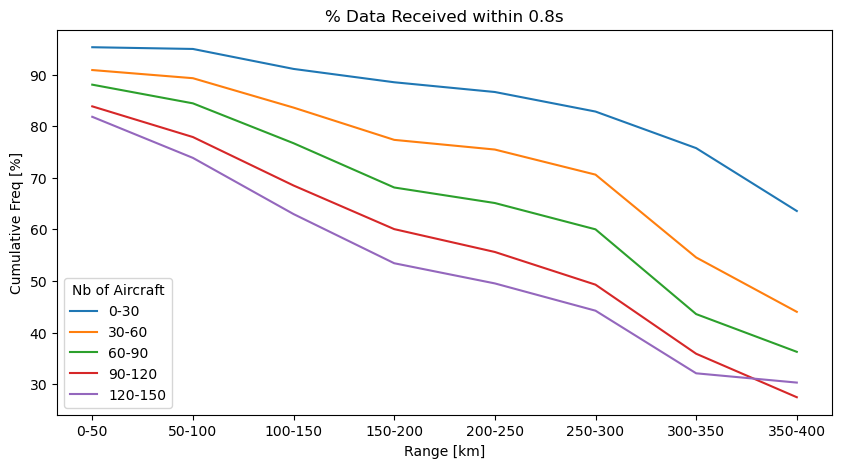

In [41]:
plt.figure(figsize=(10, 5))

for traf_list_prob in within_p5s_heatmap:
    plt.plot(traf_list_prob)
    
plt.title('% Data Received within 0.8s')
plt.ylabel('Cumulative Freq [%]')
plt.xlabel('Range [km]')

range_labels = ['{}-{}'.format(i*range_bin_width, (i+1)*range_bin_width) for i in range(8)]
traf_labels = ['{}-{}'.format(i*traf_bin_width, (i+1)*traf_bin_width) for i in range(5)]

plt.xticks(np.arange(8), range_labels, rotation = 0)  # Set text labels.
plt.legend(traf_labels, title = 'Nb of Aircraft')


In [42]:
# within_p5s_heatmap.T

range_list = [[j for i in range(5)] for j in range(8)]
traf_list = [[i for i in range(5)] for j in range(8)]

flat_range_list = []
for sublist in range_list:
    for item in sublist:
        flat_range_list.append(item)

        
flat_traf_list = []
for sublist in traf_list:
    for item in sublist:
        flat_traf_list.append(item)

flat_prob_list = []
for sublist in within_p5s_heatmap:
    for item in sublist:
        flat_prob_list.append(item)


print(flat_range_list)
print(flat_traf_list)
print(flat_prob_list)

[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7]
[0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4]
[95.28719677439588, 94.95104039169517, 91.08261384795058, 88.4977486696885, 86.60946598932591, 82.82149712093563, 75.7358351729454, 63.55291576673757, 90.8646750470965, 89.28464937248933, 83.58701313735696, 77.3362681495355, 75.46019463011338, 70.59834150365478, 54.550065207946396, 44.01273885350318, 88.03222886820731, 84.41174888055592, 76.68538951968401, 68.1062631152615, 65.09646862159134, 59.99743940861556, 43.5762247020964, 36.262448740480146, 83.8307243616109, 77.88124746119951, 68.49034017631239, 60.04142216081678, 55.6118075645924, 49.27735260814132, 35.892195857907936, 27.467105263157084, 81.805094288471, 73.84314792366024, 62.95572023237368, 53.42860888946822, 49.51994035389756, 44.234180249273614, 32.101167315178095, 30.303030303030564]


## Altitude Effect

In [103]:
df['FL'] = df['alt'] * 3.28084/100

In [105]:
df['FL']

0          370.000012
1          370.000012
2          370.000012
3          370.000012
4          370.000012
              ...    
3683105    330.000011
3683106    330.000011
3683107    330.000011
3683108    330.000011
3683109    330.000011
Name: FL, Length: 3683110, dtype: float64

0.4816132858837485 0.6499341329820426 0.7154574782071522 0.6891389344995205
1686 14423 87414 492088


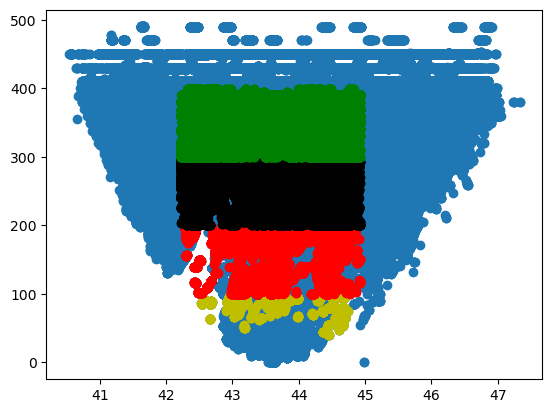

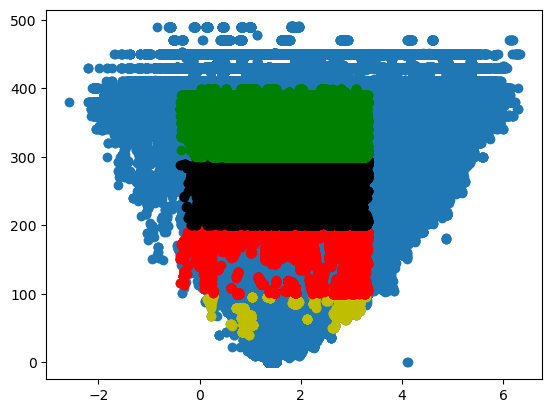

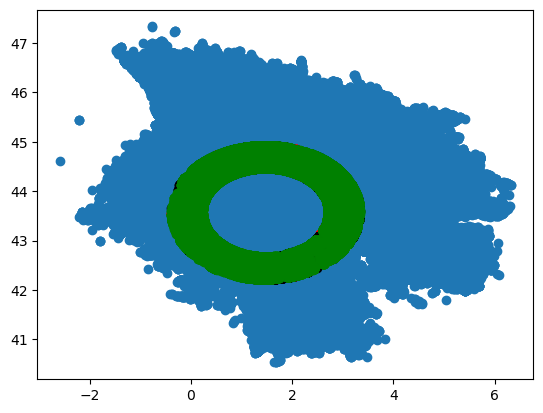

In [165]:
range_1_crit = (df['range_km'] > 100) & (df['range_km'] < 150)
alt_0_crit = (df['FL'] > 0) & (df['FL'] <= 100)
alt_1_crit = (df['FL'] > 100) & (df['FL'] <= 200)
alt_2_crit = (df['FL'] > 200) & (df['FL'] <= 300)
alt_3_crit = (df['FL'] > 300) & (df['FL'] <= 400)

df_bin_0 = df[range_1_crit & alt_0_crit]
df_bin_1 = df[range_1_crit & alt_1_crit]
df_bin_2 = df[range_1_crit & alt_2_crit]
df_bin_3 = df[range_1_crit & alt_3_crit]

plt.figure()
plt.scatter(df['lat'], df['FL'])
plt.scatter(df_bin_0['lat'], df_bin_0['FL'], color = 'y')
plt.scatter(df_bin_1['lat'], df_bin_1['FL'], color = 'r')
plt.scatter(df_bin_2['lat'], df_bin_2['FL'], color = 'k')
plt.scatter(df_bin_3['lat'], df_bin_3['FL'], color = 'g')

plt.figure()
plt.scatter(df['lon'], df['FL'])
plt.scatter(df_bin_0['lon'], df_bin_0['FL'], color = 'y')
plt.scatter(df_bin_1['lon'], df_bin_1['FL'], color = 'r')
plt.scatter(df_bin_2['lon'], df_bin_2['FL'], color = 'k')
plt.scatter(df_bin_3['lon'], df_bin_3['FL'], color = 'g')

plt.figure()
plt.scatter(df['lon'], df['lat'])
plt.scatter(df_bin_0['lon'], df_bin_0['lat'], color = 'y')
plt.scatter(df_bin_1['lon'], df_bin_1['lat'], color = 'r')
plt.scatter(df_bin_2['lon'], df_bin_2['lat'], color = 'k')
plt.scatter(df_bin_3['lon'], df_bin_3['lat'], color = 'g')

bin_0_within_p5 = df_bin_0[df_bin_0['updateinterval'] < 0.8]
bin_0_all = df_bin_0

bin_0_percentage = len(bin_0_within_p5)/len(bin_0_all)

bin_1_within_p5 = df_bin_1[df_bin_1['updateinterval'] < 0.8]
bin_1_all = df_bin_1

bin_1_percentage = len(bin_1_within_p5)/len(bin_1_all)

bin_2_within_p5 = df_bin_2[df_bin_2['updateinterval'] < 0.8]
bin_2_all = df_bin_2

bin_2_percentage = len(bin_2_within_p5)/len(bin_2_all)

bin_3_within_p5 = df_bin_3[df_bin_3['updateinterval'] < 0.8]
bin_3_all = df_bin_3

bin_3_percentage = len(bin_3_within_p5)/len(bin_3_all)

print(bin_0_percentage, bin_1_percentage, bin_2_percentage, bin_3_percentage)
print(len(bin_0_all), len(bin_1_all), len(bin_2_all), len(bin_3_all))

In [118]:
print(len(df_))
print(len(df_[df_['updateinterval'] < 0.8]))
print()


24638
13888


In [163]:
range_bin_width = 50
alt_bin_width = 100 #in flight level

max_range = 210
max_alt = 500 # in flight level

nb_alt_crit = int(max_alt/alt_bin_width)
nb_range_crit = int(max_range/range_bin_width)

dict_update_interval = {}
dict_nb_data = {}

for j in range(nb_alt_crit):
    alt_ = (df['FL'] > j*alt_bin_width) & (df['FL'] <= (j+1)*alt_bin_width)
    
    list_here = []
    list_nb_data = []
    
    for i in range(nb_range_crit):
        range_ = (df['range_km'] > i*range_bin_width) & (df['range_km'] < (i+1)*range_bin_width)
        
        print('{}-{}'.format(j*alt_bin_width, (j+1)*alt_bin_width))
        df_ = df[range_ & alt_]
        within_p5_ = df_[df_['updateinterval'] < 0.8]
        
        prob = len(within_p5_)/len(df_)
        
        print(prob, len(df_))
        list_here.append(prob)
        list_nb_data.append(len(df_))
        
    dict_update_interval['{}-{}'.format(j*alt_bin_width, (i+1)*alt_bin_width)] = list_here
    dict_nb_data['{}-{}'.format(j*alt_bin_width, (i+1)*alt_bin_width)] = list_nb_data

# range_1_crit = (df['range_km'] > 100) & (df['range_km'] < 150)
# alt_0_crit = (df['alt'] > 4000) & (df['alt'] < 6000)
# alt_1_crit = (df['alt'] > 6000) & (df['alt'] < 8000)
# alt_2_crit = (df['alt'] > 8000) & (df['alt'] < 10000)
# alt_3_crit = (df['alt'] > 10000) & (df['alt'] < 12000)

# df_bin_0 = df[range_1_crit & alt_0_crit]
# df_bin_1 = df[range_1_crit & alt_1_crit]
# df_bin_2 = df[range_1_crit & alt_2_crit]
# df_bin_3 = df[range_1_crit & alt_3_crit]

0-100
0.8498318800934632 122829
0-100
0.677695017033316 17319
0-100
0.4816132858837485 1686
0-100
0.375 112
100-200
0.8795332305853489 31793
100-200
0.792511513846522 50157
100-200
0.6499341329820426 14423
100-200
0.5200318062266805 16349
200-300
0.8582617721996791 10597
200-300
0.7812065797140424 44622
200-300
0.7154574782071522 87414
200-300
0.6459002464100603 58845
300-400
0.8287319894141862 275463
300-400
0.7813595580534631 604417
300-400
0.6891389344995205 492088
300-400
0.608068054647594 361004
400-500
0.7814776808619806 19490
400-500
0.7290612348178138 31616
400-500
0.6449697715671723 27623
400-500
0.5873160007646722 20924


In [148]:
dict_update_interval

{'0-50': [0.8498318800934632, 0.677695017033316, 0.4816132858837485, 0.375],
 '50-100': [0.8795332305853489,
  0.792511513846522,
  0.6499341329820426,
  0.5200318062266805],
 '100-150': [0.8582617721996791,
  0.7812065797140424,
  0.7154574782071522,
  0.6459002464100603],
 '150-200': [0.8287319894141862,
  0.7813595580534631,
  0.6891389344995205,
  0.608068054647594],
 '200-250': [0.7814776808619806,
  0.7290612348178138,
  0.6449697715671723,
  0.5873160007646722]}

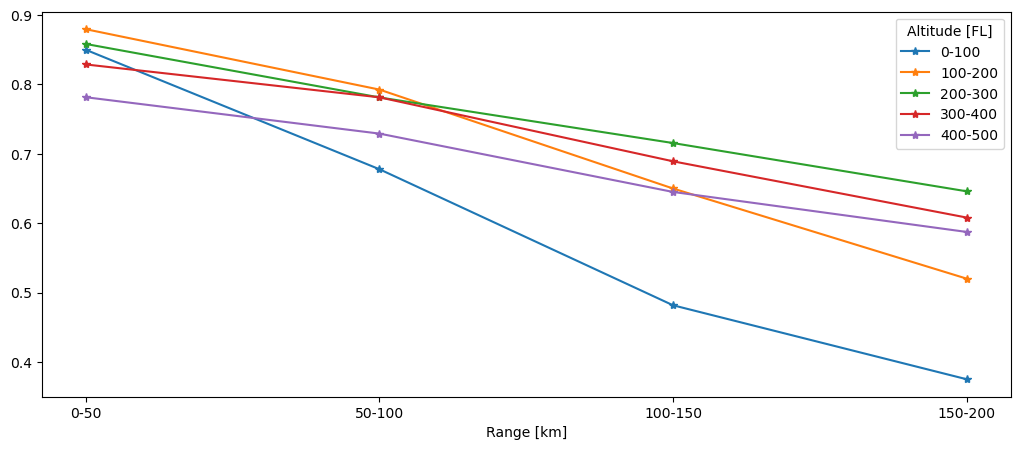

In [162]:
plt.figure(figsize= (12.5, 5))

for key in dict_update_interval.keys():
    plt.plot(dict_update_interval[key], '-*')
    
plt.xlabel('Range [km]')

range_labels_alt = ['{}-{}'.format(i*range_bin_width, (i+1)*range_bin_width) for i in range(4)]
alt_labels = ['{}-{}'.format(i*alt_bin_width, (i+1)*alt_bin_width) for i in range(5)]

plt.xticks(np.arange(4), range_labels_alt, rotation = 0)  # Set text labels.
plt.legend(alt_labels, title = 'Altitude [FL]')

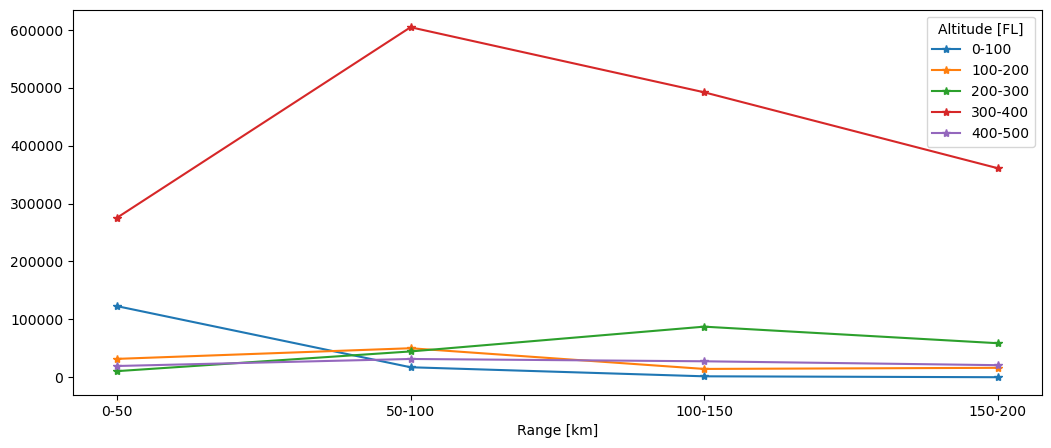

In [164]:
plt.figure(figsize= (12.5, 5))

for key in dict_nb_data.keys():
    plt.plot(dict_nb_data[key], '-*')
    
plt.xlabel('Range [km]')

range_labels_alt = ['{}-{}'.format(i*range_bin_width, (i+1)*range_bin_width) for i in range(4)]
alt_labels = ['{}-{}'.format(i*alt_bin_width, (i+1)*alt_bin_width) for i in range(5)]

plt.xticks(np.arange(4), range_labels_alt, rotation = 0)  # Set text labels.
plt.legend(alt_labels, title = 'Altitude [FL]')

## Same Density

In [170]:
df['range_km'] <= 50

0          False
1          False
2          False
3          False
4          False
           ...  
3683105    False
3683106    False
3683107    False
3683108    False
3683109    False
Name: range_km, Length: 3683110, dtype: bool

In [181]:
traf_crit_1 = (df['nb_of_traffic'] > 5) & (df['nb_of_traffic'] <= 15)
range_crit_1 = (df['range_km'] > 50) & (df['range_km'] <= 100)

traf_crit_2 = (df['nb_of_traffic'] > 15) & (df['nb_of_traffic'] <= 25)
range_crit_2 = (df['range_km'] > 100) & (df['range_km'] <= 150)

traf_crit_3 = (df['nb_of_traffic'] > 25) & (df['nb_of_traffic'] <= 35)
range_crit_3 = (df['range_km'] > 150) & (df['range_km'] <= 200)

df_density_1 = df[traf_crit_1 & range_crit_1]
df_density_2 = df[traf_crit_2 & range_crit_2]
df_density_3 = df[traf_crit_3 & range_crit_3]

In [182]:
within_p5s_dens_1 = len(df_density_1[df_density_1['updateinterval'] < 0.75])/len(df_density_1)
within_p5s_dens_2 = len(df_density_2[df_density_2['updateinterval'] < 0.75])/len(df_density_2)
within_p5s_dens_3 = len(df_density_3[df_density_3['updateinterval'] < 0.75])/len(df_density_3)

print(within_p5s_dens_1, within_p5s_dens_2, within_p5s_dens_3)

0.9588863109048724 0.8852599388379205 0.8031272210376688


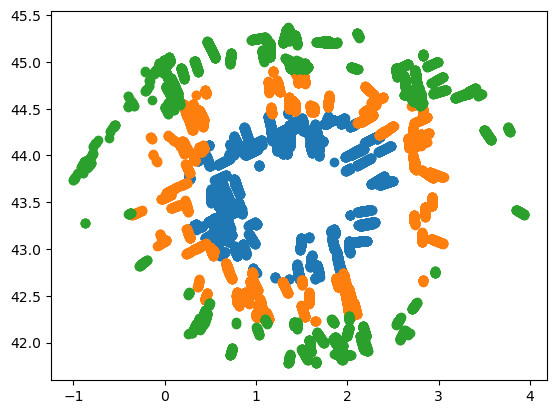

In [183]:
plt.scatter(df_density_1['lon'], df_density_1['lat'])
plt.scatter(df_density_2['lon'], df_density_2['lat'])
plt.scatter(df_density_3['lon'], df_density_3['lat'])

## Reception Probability Model

In [36]:
dict_update_prob = {}
dict_error = {}
dict_error_graph = {}
dict_pvalue = {}

range_idx = 0

initial_x_list = np.array(within_p5s)/100

for df_traf in df_all_bin:
    traf_idx = 0
    list_update_prob_traf = []
    list_error = []
    list_error_graph = []
    list_pvalue = []
    
    for df_loc in df_traf:
        initial_prob = round(initial_x_list[range_idx][traf_idx], 3)
        print("R={}-{},T={}-{},InitProb={}".format((range_idx*50), (range_idx+1)*50, (traf_idx*30), (traf_idx+1)*30, initial_prob))
        input_data = np.array(df_loc['updateinterval'].to_list())
        
        update_prob = gradient_descent(input_data, initial_x = initial_prob, learning_rate = 0.003, max_iter = 100, stop_delta = 5e-4)
        
        list_update_prob_traf.append(update_prob)

        max_diff_graph, max_diff, p_value = get_comparison(update_prob, input_data)
        
        list_error.append(max_diff*100)
        list_error_graph.append(max_diff_graph*100)
        list_pvalue.append(p_value)
        
        print("Max_Diff_Graph: {}. Max Diff: {}. P-value: {}".format(max_diff_graph, max_diff*100, p_value))
        
        traf_idx +=1
        
    dict_update_prob['R{}-{}'.format(range_idx*50, (range_idx+1)*50)] = list_update_prob_traf
    dict_error['R{}-{}'.format(range_idx*50, (range_idx+1)*50)] = list_error
    dict_error_graph['R{}-{}'.format(range_idx*50, (range_idx+1)*50)] = list_error_graph
    dict_pvalue['R{}-{}'.format(range_idx*50, (range_idx+1)*50)] = list_pvalue
        
    range_idx +=1

NameError: name 'within_p5s' is not defined

In [82]:
dict_update_prob

{'R0-50': [0.9657010162485072,
  0.9092443359172179,
  0.8796551959502458,
  0.8381937246307208,
  0.8176021175688704],
 'R50-100': [0.9504740468880233,
  0.8929551099638042,
  0.8443111931761352,
  0.7786274237061926,
  0.7367418076747259],
 'R100-150': [0.9129710748208427,
  0.8356136319448073,
  0.7667231480749851,
  0.6699620092403579,
  0.6048260968579817],
 'R150-200': [0.8855142216955297,
  0.7725777464383259,
  0.6523858064765915,
  0.5622634076905514,
  0.4998639643676358],
 'R200-250': [0.8661685985028696,
  0.7546323989496861,
  0.6190722402496022,
  0.5180780254747147,
  0.45967862317432273],
 'R250-300': [0.8276951363631302,
  0.6888418492777886,
  0.5653587608706218,
  0.4499748867196265,
  0.4006905247205028],
 'R300-350': [0.7555305366411886,
  0.5146885219495264,
  0.403586459700938,
  0.3322384347681786,
  0.28771317664167795],
 'R350-400': [0.6253983604687512,
  0.44655479409358434,
  0.37448785526993805,
  0.2833601078587303,
  0.27687774124185055]}

In [83]:
dict_error

{'R0-50': [6.7, 6.2, 4.3, 5.3, 4.7],
 'R50-100': [6.7, 5.5, 5.0, 6.6000000000000005, 6.4],
 'R100-150': [6.4, 5.8999999999999995, 6.2, 9.4, 7.3],
 'R150-200': [6.7, 5.7, 21.9, 10.100000000000001, 11.1],
 'R200-250': [7.9, 6.2, 9.3, 6.7, 10.299999999999999],
 'R250-300': [14.6, 9.3, 11.1, 12.9, 6.800000000000001],
 'R300-350': [7.000000000000001,
  13.600000000000001,
  6.800000000000001,
  7.6,
  7.199999999999999],
 'R350-400': [9.2, 9.8, 8.799999999999999, 7.8, 6.5]}

In [84]:
dict_pvalue

{'R0-50': [0.022438659451142425,
  0.042792013924212634,
  0.3136800387320582,
  0.12051526066065596,
  0.21939649929677082],
 'R50-100': [0.022438659451142425,
  0.09710349657052789,
  0.16411447756429137,
  0.025633868930359294,
  0.033253124816560224],
 'R100-150': [0.033253124816560224,
  0.06153429181321559,
  0.042792013924212634,
  0.0002883096840614359,
  0.00967775474446886],
 'R150-200': [0.022438659451142425,
  0.07761108123267829,
  2.0545862271954644e-21,
  7.335921717149848e-05,
  8.74452446093763e-06],
 'R200-250': [0.0038826726503625613,
  0.042792013924212634,
  0.00034775170271509687,
  0.022438659451142425,
  4.872295384883887e-05],
 'R250-300': [1.035413447317725e-09,
  0.00034775170271509687,
  8.74452446093763e-06,
  1.1412985810949231e-07,
  0.01960232095219542],
 'R300-350': [0.014870029418858987,
  1.767765488097077e-08,
  0.01960232095219542,
  0.006185603570160095,
  0.01118990326412112],
 'R350-400': [0.000418604197209586,
  0.00013349301651925088,
  0.00086

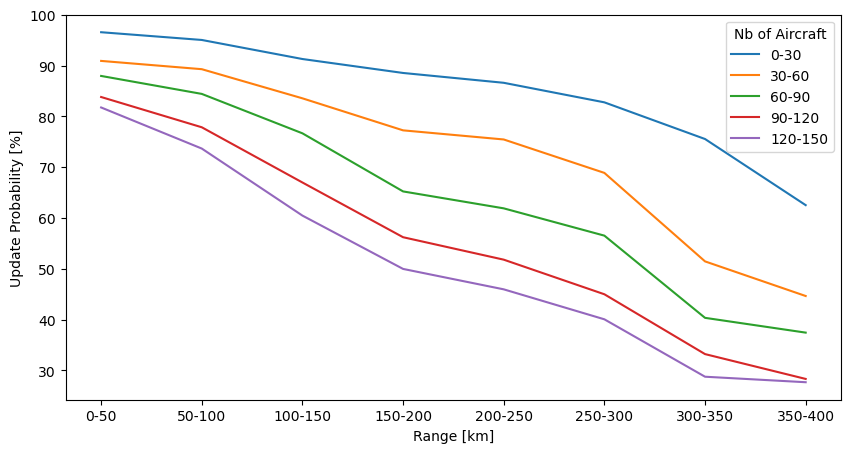

In [85]:
plt.figure(figsize=(10, 5))

range_list_prob = []

for traf_list_prob in dict_update_prob.values():
    range_list_prob.append(traf_list_prob)
    
range_list_prob = np.array(range_list_prob)

for h in range_list_prob.T:
    plt.plot(np.arange(8), h*100)
    
plt.ylabel('Update Probability [%]')
plt.xlabel('Range [km]')

range_labels = ['{}-{}'.format(i*range_bin_width, (i+1)*range_bin_width) for i in range(8)]
traf_labels = ['{}-{}'.format(i*traf_bin_width, (i+1)*traf_bin_width) for i in range(5)]

plt.xticks(np.arange(8), range_labels, rotation = 0)  # Set text labels.
plt.legend(traf_labels, title = 'Nb of Aircraft')


In [95]:
error_map = []

for val in dict_error_graph.values():
    error_map.append(np.array(val)/100)

[ 50 100 150 200 250 300 350]


(0.0, 8.0, 5.0, 0.0)

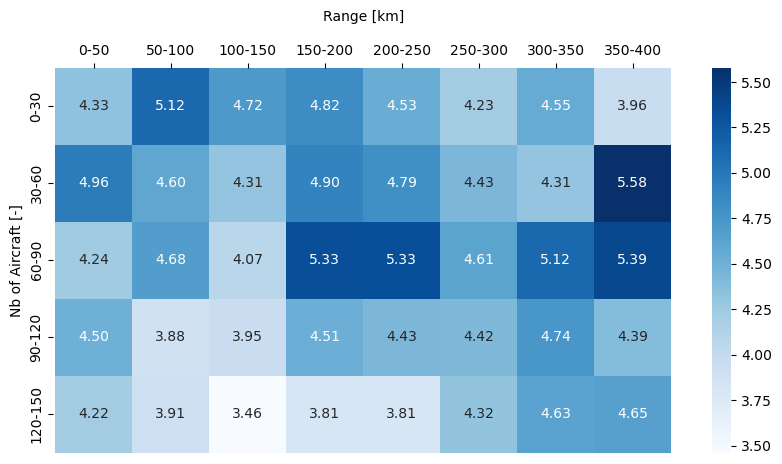

In [96]:
# Create a grid of x and y values
range_arr = np.arange(range_bin_width, max_range, range_bin_width)
traf_arr = np.arange(traf_bin_width, max_traf, traf_bin_width)
X, Y = np.meshgrid(range_arr, traf_arr)

print(range_arr)

# R_np = np.array(R_list)
error_map = np.array(error_map)

# data_flipped = data_size[::-1]

range_labels = ['{}-{}'.format(i*range_bin_width, (i+1)*range_bin_width) for i in range(nb_of_cat_range)]
traf_labels = ['{}-{}'.format(i*traf_bin_width, (i+1)*traf_bin_width) for i in range(nb_of_cat_traf)]
# traf_labels = traf_labels[::-1]

# Create a filled contour plot
plt.figure(figsize=(10, 5))
cmap_reversed = plt.get_cmap('coolwarm_r')  # Get the reversed colormap
sns.heatmap(error_map.T, annot=True, cmap='Blues', fmt='.2f', cbar=True, xticklabels=range_labels, yticklabels=traf_labels)
# Set axis labels and plot title
plt.xlabel('Range [km]')

ax = plt.gca()
ax.xaxis.set_label_coords(0.5, 1.15)  # Adjust the label position to be at the top
ax.xaxis.set_ticks_position('top')

plt.ylabel('Nb of Aircraft [-]')
plt.axis('equal')
# plt.title('Annotated Heatmap Example')

In [ ]:
input_data = np.array(df_all_bin[1][1]['updateinterval'].to_list())

get_comparison(0.915812337308451, input_data)

In [ ]:
dict_update_prob = {'R0-50': [0.954706594333095,
  0.9191169274035361,
  0.9058355992075549,
  0.8451478867685845,
  0.821234087475854],
 'R50-100': [0.9553633972781242,
  0.915812337308451,
  0.8596753287542082,
  0.814714212335178,
  0.8040557173699626]}

In [ ]:
plt.plot(dict_update_prob['R0-50'])
plt.plot(dict_update_prob['R50-100'])

xticks_l = [0, 1, 2, 3, 4]
xticks_x = ['0-30', '30-60', '60-90', '90-120', '120-150']
ax = plt.gca()
ax.set_xticks(xticks_l)
ax.set_xticklabels(xticks_x)

plt.legend(['0-50 km', '50-100 km'])